Imports for the project

In [2]:
import cv2
import os
import glob
import shutil
import numpy as np
import random
from pathlib import Path
import yaml
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt



Training Yolov8 model (without augmentation)

In [ ]:
data_yaml1_non = r"C:\Users\hossa\Downloads\License-Plate-Recognition.v2-2024-09-05-1-06am.yolov8"
model_nonAug = YOLO("yolov8n.pt")
result1_non = model_nonAug.train(data = data_yaml1_non , epochs = 30) 

Getting the best epoch of the model and testing it


image 1/1 C:\Users\hossa\Downloads\elyb3do.jpg: 640x640 5 licenseplates, 23.9ms
Speed: 4.4ms preprocess, 23.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

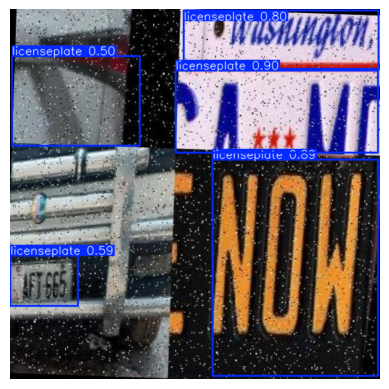

In [6]:
model1_nonAug = YOLO(r"C:\Users\hossa\Downloads\VCIP\Models\best non Augmented.pt")
result1_nonAug = model1_nonAug(r"C:\Users\hossa\Downloads\elyb3do.jpg" , iou = 0)

img = result1_nonAug[0].plot()
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')

Augmentation function

In [7]:
import os
import glob
import shutil
import random
import cv2
import numpy as np

# helper to list image files by extension (case‑insensitive)
def list_image_files(directory):
    exts = {'.jpg', '.jpeg', '.png'}
    all_files = glob.glob(os.path.join(directory, '*'))
    return [f for f in all_files if os.path.splitext(f)[1].lower() in exts]

MAX_AUG_IMAGES = 3000   # number of augmentations for train
VAL_RATIO      = 0.30   # 30% of MAX_AUG_IMAGES for valid

# augmentation funcs
def rotate_image(img, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

def adjust_brightness_contrast(img, brightness=0, contrast=0):
    return cv2.convertScaleAbs(img, alpha=1+contrast/100.0, beta=brightness)

def apply_motion_blur(img, size=5):
    k = np.zeros((size, size)); k[size//2, :] = 1; k /= size
    return cv2.filter2D(img, -1, k)

def add_gaussian_noise(img, mean=0, std=10):
    gauss = np.random.normal(mean, std, img.shape).astype(np.uint8)
    return cv2.add(img, gauss)

def invert_colors(img):
    return cv2.bitwise_not(img)

# main augmenation
def augment_images(src_img_dir, src_lbl_dir, dst_img_dir, dst_lbl_dir, max_aug):
    os.makedirs(dst_img_dir, exist_ok=True)
    os.makedirs(dst_lbl_dir, exist_ok=True)
    generated = 0

    all_imgs = list_image_files(src_img_dir)
    random.shuffle(all_imgs)

    for img_path in all_imgs:
        if generated >= max_aug:
            break

        base    = os.path.splitext(os.path.basename(img_path))[0]
        lbl_src = os.path.join(src_lbl_dir, base + '.txt')

        if not os.path.exists(lbl_src) or os.path.getsize(lbl_src) == 0:
            continue

        lines = open(lbl_src).readlines()
        if not lines:
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        # build augment list
        aug_list = [
            (cv2.flip(img,1), '_flip'),
            (invert_colors(img), '_invert'),
            (add_gaussian_noise(img), '_noise'),
            (adjust_brightness_contrast(img,30,40), '_bright1'),
            (adjust_brightness_contrast(img,-30,-30), '_bright2'),
            (apply_motion_blur(img,5), '_blur5'),
            (apply_motion_blur(img,7), '_blur7'),
        ]
        for a in (-30,-20,-10,10,20,30):
            aug_list.append((rotate_image(img,a), f'_rot{a}'))

        for aug_img, suffix in aug_list:
            if generated >= max_aug:
                break
            out_img = os.path.join(dst_img_dir, base + suffix + '.jpg')
            out_lbl = os.path.join(dst_lbl_dir, base + suffix + '.txt')
            cv2.imwrite(out_img, aug_img)
            shutil.copy(lbl_src, out_lbl)
            generated += 1

    print(f"[AUGMENT] Generated {generated} images in {os.path.basename(dst_img_dir)}")

# cleaning 
def clean_unlabeled_images(img_dir, lbl_dir):
    removed = 0
    for img_path in list_image_files(img_dir):
        base     = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(lbl_dir, base + '.txt')

        if not os.path.exists(lbl_path) or os.path.getsize(lbl_path) == 0:
            os.remove(img_path)
            if os.path.exists(lbl_path):
                os.remove(lbl_path)
            removed += 1
            continue

        lines = open(lbl_path).readlines()
        if not lines:
            os.remove(img_path)
            os.remove(lbl_path)
            removed += 1

    print(f"[CLEANUP] Removed {removed} invalid samples in {os.path.basename(img_dir)}")

# === COPY ORIGINAL data.yaml VERBATIM ===
def copy_data_yaml(original_root, output_root):
    src = os.path.join(original_root, 'data.yaml')
    dst = os.path.join(output_root,   'data.yaml')
    shutil.copy(src, dst)
    print(f"[YAML] Copied data.yaml → {dst}")


def locate_split_dirs(root, split):
    return os.path.join(root, split, 'images'), os.path.join(root, split, 'labels')

def run_full_augmentation_pipeline(original_root, output_root):
    plan = {
        'train': MAX_AUG_IMAGES,
        'valid': int(MAX_AUG_IMAGES * VAL_RATIO)
    }

    for split in ('train', 'valid'):
        print(f"\n--- Processing {split.upper()} ---")
        src_i, src_l = locate_split_dirs(original_root, split)
        dst_i = os.path.join(output_root, split, 'images')
        dst_l = os.path.join(output_root, split, 'labels')
        os.makedirs(dst_i, exist_ok=True)
        os.makedirs(dst_l, exist_ok=True)

        count = 0
        for img_path in list_image_files(src_i):
            base    = os.path.splitext(os.path.basename(img_path))[0]
            lbl_src = os.path.join(src_l, base + '.txt')
            dst_img = os.path.join(dst_i, base + '.jpg')
            dst_lbl = os.path.join(dst_l, base + '.txt')

            img = cv2.imread(img_path)
            if img is None:
                continue

            if not os.path.exists(lbl_src) or os.path.getsize(lbl_src) == 0:
                continue

            lines = open(lbl_src).readlines()
            if not lines:
                continue

            shutil.copy(img_path, dst_img)
            shutil.copy(lbl_src, dst_lbl)
            count += 1

        print(f"[COPY] {count} valid originals to {split}")

        augment_images(src_i, src_l, dst_i, dst_l, plan[split])
        clean_unlabeled_images(dst_i, dst_l)

    print("\n--- Copying TEST split ---")
    src_i, src_l = locate_split_dirs(original_root, 'test')
    dst_i = os.path.join(output_root, 'test', 'images')
    dst_l = os.path.join(output_root, 'test', 'labels')
    os.makedirs(dst_i, exist_ok=True)
    os.makedirs(dst_l, exist_ok=True)
    for img in list_image_files(src_i):
        base = os.path.splitext(os.path.basename(img))[0]
        shutil.copy(img, os.path.join(dst_i, base + '.jpg'))
        lbl = os.path.join(src_l, base + '.txt')
        if os.path.exists(lbl):
            shutil.copy(lbl, os.path.join(dst_l, base + '.txt'))
    print(f"[COPY] Test images copied: {len(list_image_files(dst_i))}")

    print("\n--- Deduplicating TEST from TRAIN/VALID ---")
    test_bases = {
        os.path.splitext(os.path.basename(p))[0]
        for p in list_image_files(dst_i)
    }
    removed = 0
    for split in ('train', 'valid'):
        ti = os.path.join(output_root, split, 'images')
        tl = os.path.join(output_root, split, 'labels')
        for base in test_bases:
            img_f = os.path.join(ti, base + '.jpg')
            lbl_f = os.path.join(tl, base + '.txt')
            if os.path.exists(img_f):
                os.remove(img_f); removed += 1
            if os.path.exists(lbl_f):
                os.remove(lbl_f)
    print(f"[DEDUPE] Removed {removed} duplicates from train/valid")

    copy_data_yaml(original_root, output_root)


To run 
Augemntation function (main runner cell)

In [140]:
if __name__ == '__main__':
    original_dataset = r"C:\Users\hossa\Downloads\License-Plate-Recognition.v2-2024-09-05-1-06am.yolov8"
    output_dataset   = r"C:\Users\hossa\Downloads\Augmented_License-Plate233"
    run_full_augmentation_pipeline(original_dataset, output_dataset)



--- Processing TRAIN ---
[COPY] 6685 valid originals to train
[AUGMENT] Generated 3000 images in images
[CLEANUP] Removed 0 invalid samples in images

--- Processing VALID ---
[COPY] 1911 valid originals to valid
[AUGMENT] Generated 900 images in images
[CLEANUP] Removed 0 invalid samples in images

--- Copying TEST split ---
[COPY] Test images copied: 955

--- Deduplicating TEST from TRAIN/VALID ---
[DEDUPE] Removed 0 duplicates from train/valid
[YAML] Copied data.yaml → C:\Users\hossa\Downloads\Augmented_License-Plate233\data.yaml


Helper function to check for duplicates after augmentation (just for testing)

In [8]:
import os
from pathlib import Path

valid_dir = Path(r"C:\Users\hossa\Downloads\Augmented_License-Plate233\valid\images")
train_dir = Path(r"C:\Users\hossa\Downloads\Augmented_License-Plate233\train\images")

valid_names = {p.name for p in valid_dir.glob("*.jpg")}
train_names = {p.name for p in train_dir.glob("*.jpg")}


duplicates = valid_names & train_names

print(f"Found {len(duplicates)} duplicate image files:\n")
for name in sorted(duplicates):
    print(name)


Found 0 duplicate image files:



Training and testing the yolov8n.pt version "n variation" after augmentation 

In [63]:
data_yaml2_aug = r"C:\Users\hossa\Downloads\Augmented_License-Plate\data.yaml"
model2_aug = YOLO("yolov8n.pt")
model2_aug.train(
    data=data_yaml2,
    epochs=30,
)

New https://pypi.org/project/ultralytics/8.3.111 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.107  Python-3.13.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Users\hossa\Downloads\Practice Oct 5th.v2i.yolov8\data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train42, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=

train: Scanning C:\Users\hossa\Downloads\Practice Oct 5th.v2i.yolov8\train\labels... 281 images, 0 backgrounds, 0 corru

train: New cache created: C:\Users\hossa\Downloads\Practice Oct 5th.v2i.yolov8\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\hossa\Downloads\Practice Oct 5th.v2i.yolov8\valid\labels... 35 images, 0 backgrounds, 0 corrupt:

val: New cache created: C:\Users\hossa\Downloads\Practice Oct 5th.v2i.yolov8\valid\labels.cache


Plotting labels to runs\detect\train42\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000278, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train42
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       5.9G      1.244       4.39      1.297        108        640: 100%|██████████| 18/18 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<0

                   all         35        223          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       5.9G      1.075      4.193      1.162         89        640: 100%|██████████| 18/18 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       5.9G      1.044      3.915      1.131         99        640: 100%|██████████| 18/18 [00:02<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223     0.0436      0.379     0.0608     0.0533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       5.9G      1.019      3.691      1.134         74        640: 100%|██████████| 18/18 [00:02<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223     0.0495      0.544     0.0925     0.0795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       5.9G     0.9642      3.486      1.109         88        640: 100%|██████████| 18/18 [00:02<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223     0.0431      0.834      0.163      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.91G      1.006      3.333      1.133         99        640: 100%|██████████| 18/18 [00:02<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.535      0.212      0.219      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      5.93G     0.9835      3.122      1.134        100        640: 100%|██████████| 18/18 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223       0.82      0.194      0.363      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.95G     0.9935      2.932      1.148         88        640: 100%|██████████| 18/18 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.587      0.343      0.402      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      5.96G      1.011      2.809      1.165        119        640: 100%|██████████| 18/18 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223       0.39      0.521      0.472      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.98G     0.9997      2.656      1.152         89        640: 100%|██████████| 18/18 [00:04<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.616      0.417      0.526       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         6G     0.9848      2.467      1.141         92        640: 100%|██████████| 18/18 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.729      0.465      0.597      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.02G     0.9966       2.41      1.154         72        640: 100%|██████████| 18/18 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223       0.58      0.571      0.674      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.03G     0.9459       2.22      1.131         88        640: 100%|██████████| 18/18 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.683      0.576      0.716      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.05G     0.9417      2.145      1.148         88        640: 100%|██████████| 18/18 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.683      0.605      0.722       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.07G     0.9471      2.074      1.145        133        640: 100%|██████████| 18/18 [00:02<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.756       0.64      0.767      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      6.08G      0.919      2.027      1.118        114        640: 100%|██████████| 18/18 [00:02<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.832      0.641      0.799       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30       6.1G     0.8945      1.927      1.104        102        640: 100%|██████████| 18/18 [00:02<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.883      0.632      0.792      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      6.12G     0.9001      1.849      1.113         95        640: 100%|██████████| 18/18 [00:02<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.857      0.664      0.816      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      6.13G     0.8773      1.772      1.105        121        640: 100%|██████████| 18/18 [00:02<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.892      0.688      0.829      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      6.15G     0.8839      1.711      1.107        118        640: 100%|██████████| 18/18 [00:02<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.782      0.751       0.85      0.721


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.17G     0.7481      1.413      1.078         55        640: 100%|██████████| 18/18 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.793      0.807      0.864      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.19G     0.7646      1.446      1.078         61        640: 100%|██████████| 18/18 [00:03<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.828      0.798      0.883      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30       6.2G     0.7181      1.291      1.067         43        640: 100%|██████████| 18/18 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223       0.85      0.792      0.889      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.22G     0.7101      1.261      1.054         69        640: 100%|██████████| 18/18 [00:02<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.853      0.835      0.901      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.24G     0.7116      1.241      1.061         62        640: 100%|██████████| 18/18 [00:02<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.836      0.831      0.896      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.26G     0.7145      1.233      1.048         64        640: 100%|██████████| 18/18 [00:02<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.837      0.841      0.902      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.27G     0.7062      1.177      1.058         61        640: 100%|██████████| 18/18 [00:02<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.893      0.823      0.911      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.29G     0.6809      1.168      1.044         44        640: 100%|██████████| 18/18 [00:02<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.946      0.808      0.919      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.31G     0.6862      1.146      1.029         58        640: 100%|██████████| 18/18 [00:02<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all         35        223       0.94      0.825       0.92      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.32G     0.6836      1.135      1.029         64        640: 100%|██████████| 18/18 [00:02<00:00,  8.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0

                   all         35        223      0.941      0.828      0.922      0.786



30 epochs completed in 0.042 hours.
Optimizer stripped from runs\detect\train42\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train42\weights\best.pt, 6.3MB

Validating runs\detect\train42\weights\best.pt...
Ultralytics 8.3.107  Python-3.13.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,011,888 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<0


                   all         35        223      0.942      0.824       0.92      0.789
                     1          7          7          1      0.991      0.995      0.746
                    10          4          4      0.988          1      0.995      0.858
                    11          6          6      0.927        0.5      0.679      0.547
                    12          9         11          1      0.711      0.995      0.882
                    13          4          5       0.94          1      0.995      0.895
                    14          6          6      0.903      0.667       0.83      0.706
                    15          8          8      0.963        0.5      0.741      0.659
                    16          5          5          1      0.656      0.851      0.719
                    17          8          8          1      0.927      0.995       0.86
                    18          6          9          1      0.714      0.995      0.871
                    1

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001E292600D00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039


image 1/1 C:\Users\hossa\Downloads\elyb3do.jpg: 640x640 2 0s, 24.1ms
Speed: 3.9ms preprocess, 24.1ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

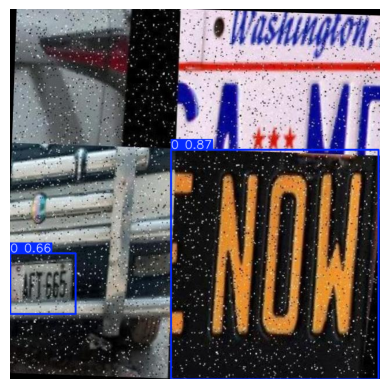

In [9]:
model2_Aug = YOLO(r"C:\Users\hossa\Downloads\VCIP\Models\best Augmented v8.pt")
result2_Aug = model2_Aug(r"C:\Users\hossa\Downloads\elyb3do.jpg", iou = 0)

img2 = result2_Aug[0].plot()
img2 = cv2.cvtColor(img2 , cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.axis('off')

Training and testing the YOLOv10.pt version "n variation" with augmented dataset 

In [146]:
data_yaml3_v10 = r"C:\Users\hossa\Downloads\Augmented_License-Plate\data.yaml"
model_v10 = YOLO("yolov10.pt")
model_v10.train(
    data=data_yaml3_v10,
    epochs=30,
)

FileNotFoundError: [Errno 2] No such file or directory: 'yolov10.pt'


image 1/1 C:\Users\hossa\Downloads\elyb3do.jpg: 640x640 3 0s, 30.1ms
Speed: 4.2ms preprocess, 30.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

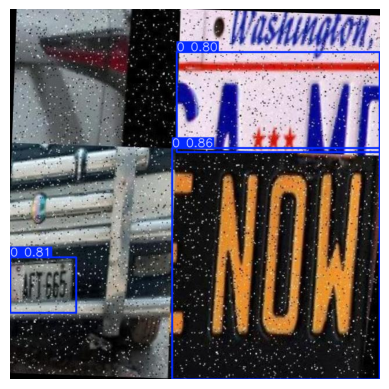

In [10]:
model3_v10 = YOLO(r"C:\Users\hossa\Downloads\VCIP\Models\best n10.pt")
result3_v10 = model3_v10(r"C:\Users\hossa\Downloads\elyb3do.jpg", iou = 0)

img3 = result3_v10[0].plot()
img3 = cv2.cvtColor(img3 , cv2.COLOR_BGR2RGB)
plt.imshow(img3)
plt.axis('off')


training and testing the  yolov11n.pt version "n variation" after augmentation

In [132]:
data_yaml11 = r"C:\Users\hossa\Downloads\Augmented_License-Plate\data.yaml"
model11 = YOLO("YOLO11n.pt")  

result11 = model11.train(data=data_yaml11,
    epochs=30,)


New https://pypi.org/project/ultralytics/8.3.111 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.107  Python-3.13.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=YOLO11n.pt, data=C:\Users\hossa\Downloads\Augmented_License-Plate\data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train46, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fals

train: Scanning C:\Users\hossa\Downloads\Augmented_License-Plate\train\labels.cache... 9685 images, 0 backgrounds, 0 co

train: WARNING  C:\Users\hossa\Downloads\Augmented_License-Plate\train\images\Image_15_png_jpg.rf.9fb322673c5344884427abba8f0823bf.jpg: 1 duplicate labels removed
WARNING  Box and segment counts should be equal, but got len(segments) = 7407, len(boxes) = 11888. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


KeyboardInterrupt: 


image 1/1 C:\Users\hossa\Downloads\elyb3do.jpg: 640x640 2 0s, 23.5ms
Speed: 3.5ms preprocess, 23.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

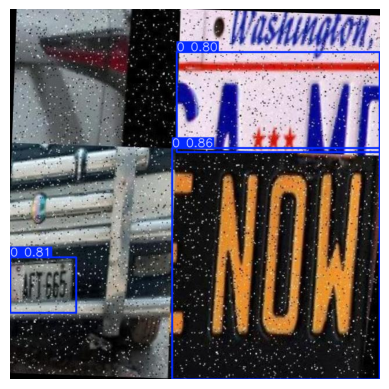

In [12]:
model4_v11 = YOLO(r"C:\Users\hossa\Downloads\VCIP\Models\best V11.pt")
result4_v11 = model4_v11(r"C:\Users\hossa\Downloads\elyb3do.jpg", iou = 0)

img4 = result4_v11[0].plot()
img4 = cv2.cvtColor(img4 , cv2.COLOR_BGR2RGB)
plt.imshow(img3)
plt.axis('off')


In [128]:
yaml_path = r"C:\Users\hossa\Downloads\Augmented_License-Plate\data.yaml"

# Run validation on each model
results1_8non = model1_nonAug.val(data=yaml_path)
results2_8aug = model2_Aug.val(data=yaml_path)
results3_10n = model3_v10.val(data=yaml_path)
results4_11n = model4_v11.val(data=yaml_path)


Ultralytics 8.3.107  Python-3.13.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)


val: Scanning C:\Users\hossa\Downloads\Augmented_License-Plate\valid\labels.cache... 2811 images, 0 backgrounds, 0 corr

WARNING  Box and segment counts should be equal, but got len(segments) = 2112, len(boxes) = 3335. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [02:


                   all       2811       3335      0.752      0.675      0.683      0.439
Speed: 3.3ms preprocess, 38.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\val12
Ultralytics 8.3.107  Python-3.13.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)


val: Scanning C:\Users\hossa\Downloads\Augmented_License-Plate\valid\labels.cache... 2811 images, 0 backgrounds, 0 corr

WARNING  Box and segment counts should be equal, but got len(segments) = 2112, len(boxes) = 3335. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [02:


                   all       2811       3335      0.907      0.826      0.834      0.647
Speed: 3.4ms preprocess, 39.1ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\val13
Ultralytics 8.3.107  Python-3.13.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)


val: Scanning C:\Users\hossa\Downloads\Augmented_License-Plate\valid\labels.cache... 2811 images, 0 backgrounds, 0 corr

WARNING  Box and segment counts should be equal, but got len(segments) = 2112, len(boxes) = 3335. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [02:


                   all       2811       3335      0.935      0.825       0.89      0.715
Speed: 3.4ms preprocess, 42.2ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs\detect\val14
Ultralytics 8.3.107  Python-3.13.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)


val: Scanning C:\Users\hossa\Downloads\Augmented_License-Plate\valid\labels.cache... 2811 images, 0 backgrounds, 0 corr

WARNING  Box and segment counts should be equal, but got len(segments) = 2112, len(boxes) = 3335. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [02:


                   all       2811       3335      0.937      0.829      0.888      0.705
Speed: 3.3ms preprocess, 48.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\val15


In [103]:
# Choose an image or folder for inference
image_path = r"C:\Users\hossa\Downloads\BLURD.jpg"
folder_path = r"C:\Users\hossa\Downloads\sample_batch"

# Predict with each model (can be image or folder)
model8n.predict(source=image_path, save=True, conf=0.25)
model8x.predict(source=image_path, save=True, conf=0.25)
model11n.predict(source=image_path, save=True, conf=0.25)


image 1/1 C:\Users\hossa\Downloads\BLURD.jpg: 448x640 1 licenseplate, 48.8ms
Speed: 3.4ms preprocess, 48.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict

image 1/1 C:\Users\hossa\Downloads\BLURD.jpg: 448x640 1 0, 48.4ms
Speed: 3.2ms preprocess, 48.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict2

image 1/1 C:\Users\hossa\Downloads\BLURD.jpg: 448x640 1 0, 58.8ms
Speed: 2.9ms preprocess, 58.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict3


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: '0'}
 obb: None
 orig_img: array([[[ 87,  87,  73],
         [ 90,  90,  76],
         [ 90,  90,  76],
         ...,
         [ 43,  43,  43],
         [ 37,  37,  37],
         [ 32,  32,  32]],
 
        [[ 93,  93,  79],
         [ 96,  96,  82],
         [ 96,  96,  82],
         ...,
         [ 43,  43,  43],
         [ 36,  36,  36],
         [ 32,  32,  32]],
 
        [[ 90,  90,  76],
         [ 93,  93,  79],
         [ 93,  93,  79],
         ...,
         [ 39,  39,  39],
         [ 33,  33,  33],
         [ 29,  29,  29]],
 
        ...,
 
        [[  4,   6,   6],
         [  4,   6,   6],
         [  5,   7,   7],
         ...,
         [ 85,  87,  98],
         [ 87,  89, 100],
         [ 89,  91, 102]],
 
        [[  3,   5,   5],
         [  4,   6,   6],
         [  5,   7,   7],
         ...,
         [ 87,  89, 100

Attempting to train a yolo.pt model using 'x' variation

In [136]:
data_yamlx = r"C:\Users\hossa\Downloads\Augmented_License-Plate\data.yaml"
modelx = YOLO("yolov8x.pt")  

resultx = modelx.train(data=data_yaml11,
    epochs=30,)


New https://pypi.org/project/ultralytics/8.3.111 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.107  Python-3.13.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8x.pt, data=C:\Users\hossa\Downloads\Augmented_License-Plate\data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train47, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fals

train: Scanning C:\Users\hossa\Downloads\Augmented_License-Plate\train\labels.cache... 9685 images, 0 backgrounds, 0 co

train: WARNING  C:\Users\hossa\Downloads\Augmented_License-Plate\train\images\Image_15_png_jpg.rf.9fb322673c5344884427abba8f0823bf.jpg: 1 duplicate labels removed
WARNING  Box and segment counts should be equal, but got len(segments) = 7407, len(boxes) = 11888. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\hossa\Downloads\Augmented_License-Plate\valid\labels.cache... 2811 images, 0 backgrounds, 0 corr

WARNING  Box and segment counts should be equal, but got len(segments) = 2112, len(boxes) = 3335. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000027AAADAC860>
Traceback (most recent call last):
  File "C:\Users\hossa\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "C:\Users\hossa\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py", line 1576, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


KeyboardInterrupt: 

Image enhancing function applied before using OCR for higher accuracy 

In [13]:
import cv2
import numpy as np

def enhance_image(image):
    # Step 1: Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 2: Denoising
    denoised = cv2.fastNlMeansDenoising(gray, None, h=10, templateWindowSize=7, searchWindowSize=21)

    # Step 3: CLAHE to improve contrast
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    contrast = clahe.apply(denoised)

    # Step 4: Slight Gaussian blur (reduce speckle)
    blurred = cv2.GaussianBlur(contrast, (3, 3), 0)

    # Step 5: Normalize to 0–255
    normalized = cv2.normalize(blurred, None, 0, 255, cv2.NORM_MINMAX)

    grays = cv2.cvtColor(normalized, cv2.COLOR_BGR2RGB)
    return grays


Using the model with the highest (MODEL 10) accuracy to crop the license plate in the image and then use OCR to extract the text in the image


0: 512x640 1 0, 28.5ms
Speed: 3.1ms preprocess, 28.5ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


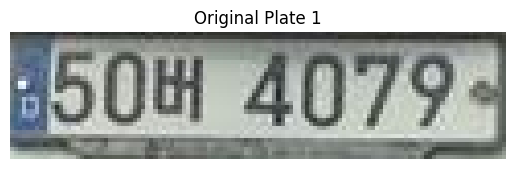

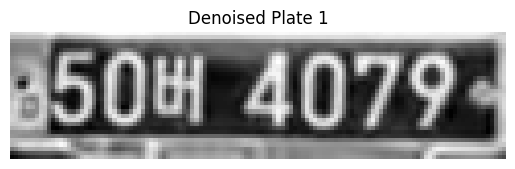


[PaddleOCR Output for Plate 1]
[OCR] 50버 (conf: 0.96)
[OCR] 4079 (conf: 1.00)


In [35]:
from ultralytics import YOLO
import cv2
import numpy as np
from matplotlib import pyplot as plt
from paddleocr import PaddleOCR


# === Initialize PaddleOCR ===
ocr = PaddleOCR(use_angle_cls=True, lang='korean', show_log=False)

# === Load YOLO license plate detection model ===
model = YOLO(r"C:\Users\hossa\Downloads\VCIP\Models\best n10.pt")

# === Load image ===
img_path = r"C:\Users\hossa\Downloads\kor2.jpg"
img = cv2.imread(img_path)

# === Run license plate detection ===
results = model(img, conf=0.25, iou=0.0)

# === Loop through detected plates ===
for r in results:
    for i, box in enumerate(r.boxes.xyxy):
        x1, y1, x2, y2 = map(int, box.tolist())
        plate_crop = img[y1:y2, x1:x2]

        # === Optional: Show the original crop ===
        plt.imshow(cv2.cvtColor(plate_crop, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Plate {i+1}")
        plt.axis('off')
        plt.show()

        # === Call simple denoising enhancement ===
        enhanced = 255 - enhance_image(plate_crop)

        # === Optional: Show the enhanced image ===
        plt.imshow(enhanced, cmap='gray')
        plt.title(f"Denoised Plate {i+1}")
        plt.axis('off')
        plt.show()

        # === OCR using PaddleOCR ===
        print(f"\n[PaddleOCR Output for Plate {i+1}]")
        ocr_result = ocr.ocr(enhanced, cls=True)

        if ocr_result and ocr_result[0]:
            for line in ocr_result[0]:
                text = line[1][0]
                conf = line[1][1]
                print(f"[OCR] {text} (conf: {conf:.2f})")
        else:
            print("[OCR] No text detected")



0: 448x640 1 0, 24.7ms
Speed: 2.0ms preprocess, 24.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


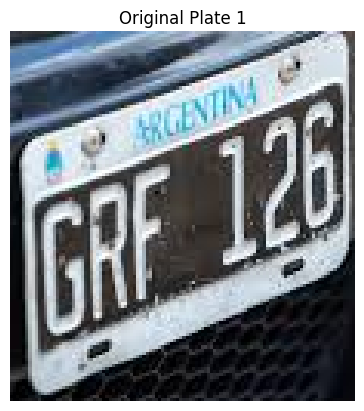

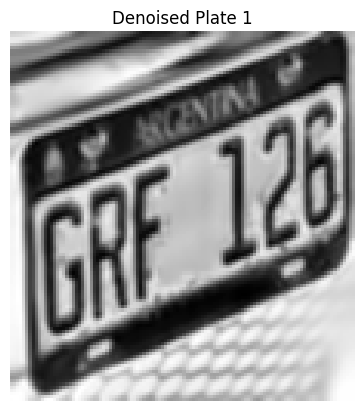


[PaddleOCR Output for Plate 1]
[OCR] GRF 126 (conf: 0.93)


In [41]:
from ultralytics import YOLO
import cv2
import numpy as np
from matplotlib import pyplot as plt
from paddleocr import PaddleOCR


# === Initialize PaddleOCR ===
ocr = PaddleOCR(use_angle_cls=True, lang='en', show_log=False)

# === Load YOLO license plate detection model ===
model = YOLO(r"C:\Users\hossa\Downloads\VCIP\Models\best n10.pt")

# === Load image ===
img_path = r"C:\Users\hossa\Downloads\VCIP\Images\GRF 126.jpeg"
img = cv2.imread(img_path)

# === Run license plate detection ===
results = model(img, conf=0.25, iou=0.0)

# === Loop through detected plates ===
for r in results:
    for i, box in enumerate(r.boxes.xyxy):
        x1, y1, x2, y2 = map(int, box.tolist())
        plate_crop = img[y1:y2, x1:x2]

        # === Optional: Show the original crop ===
        plt.imshow(cv2.cvtColor(plate_crop, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Plate {i+1}")
        plt.axis('off')
        plt.show()

        # === Call simple denoising enhancement ===
        enhanced = 255 - enhance_image(plate_crop)

        # === Optional: Show the enhanced image ===
        plt.imshow(enhanced, cmap='gray')
        plt.title(f"Denoised Plate {i+1}")
        plt.axis('off')
        plt.show()

        # === OCR using PaddleOCR ===
        print(f"\n[PaddleOCR Output for Plate {i+1}]")
        ocr_result = ocr.ocr(enhanced, cls=True)

        if ocr_result and ocr_result[0]:
            for line in ocr_result[0]:
                text = line[1][0]
                conf = line[1][1]
                print(f"[OCR] {text} (conf: {conf:.2f})")
        else:
            print("[OCR] No text detected")
